<a href="https://colab.research.google.com/github/shreyasnagooor/Voice-Based-Biometric-System-One-Shot-Learning-for-Unseen-Speaker-Generalization/blob/main/VoiceAuthentication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio librosa matplotlib seaborn scikit-learn audiomentations

import torch
import torchaudio
import torchaudio.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import os

from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils.rnn import pad_sequence
from torchvision import models

import matplotlib.pyplot as plt
import librosa.display
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.manifold import TSNE

from IPython.display import Audio, display
from tqdm import tqdm

from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 17.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


Using device: cpu


In [ ]:
librispeech_dataset = torchaudio.datasets.LIBRISPEECH(
    root=".",
    url="train-clean-100",
    download=True
)

def play_audio(waveform, sample_rate):
    display(Audio(waveform.numpy(), rate=sample_rate))

sample_waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = librispeech_dataset[0]
print(f"Sample Rate: {sample_rate}")
print(f"Speaker ID: {speaker_id}, Chapter ID: {chapter_id}, Utterance ID: {utterance_id}")
print(f"Transcript: {utterance}")
print(f"Waveform shape: {sample_waveform.shape}")

play_audio(sample_waveform, sample_rate)


100%|██████████| 5.95G/5.95G [05:31<00:00, 19.3MB/s]


Sample Rate: 16000
Speaker ID: 103, Chapter ID: 1240, Utterance ID: 0
Transcript: CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK
Waveform shape: torch.Size([1, 225360])


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


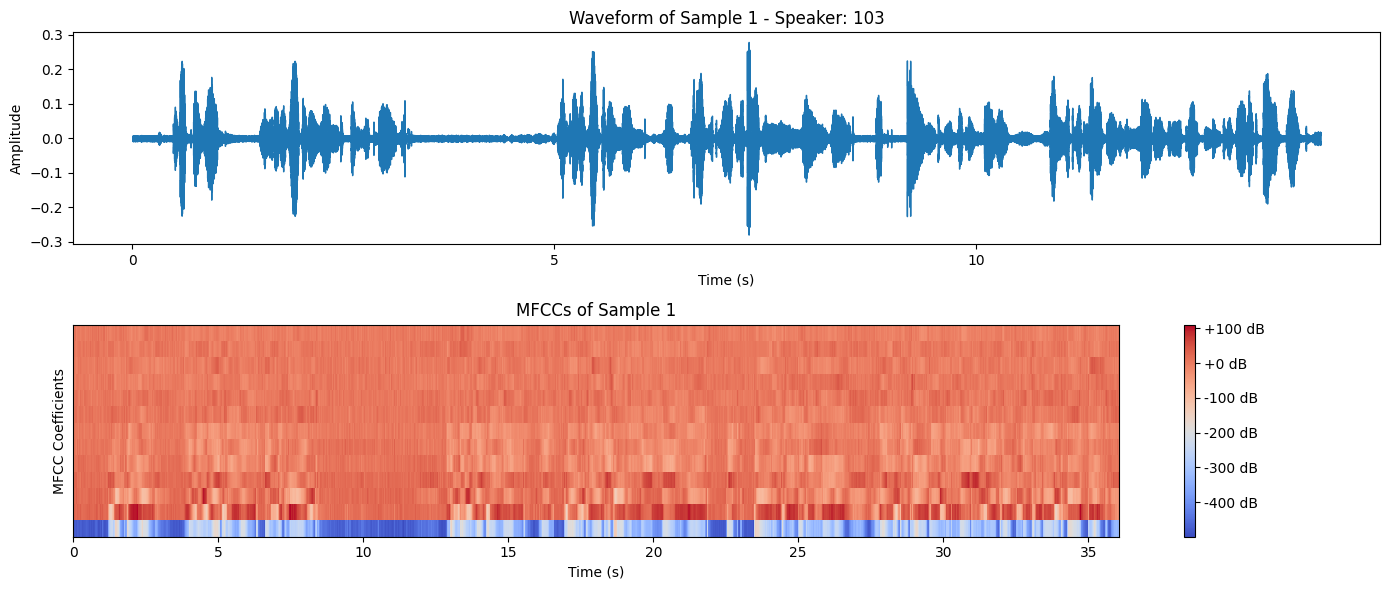

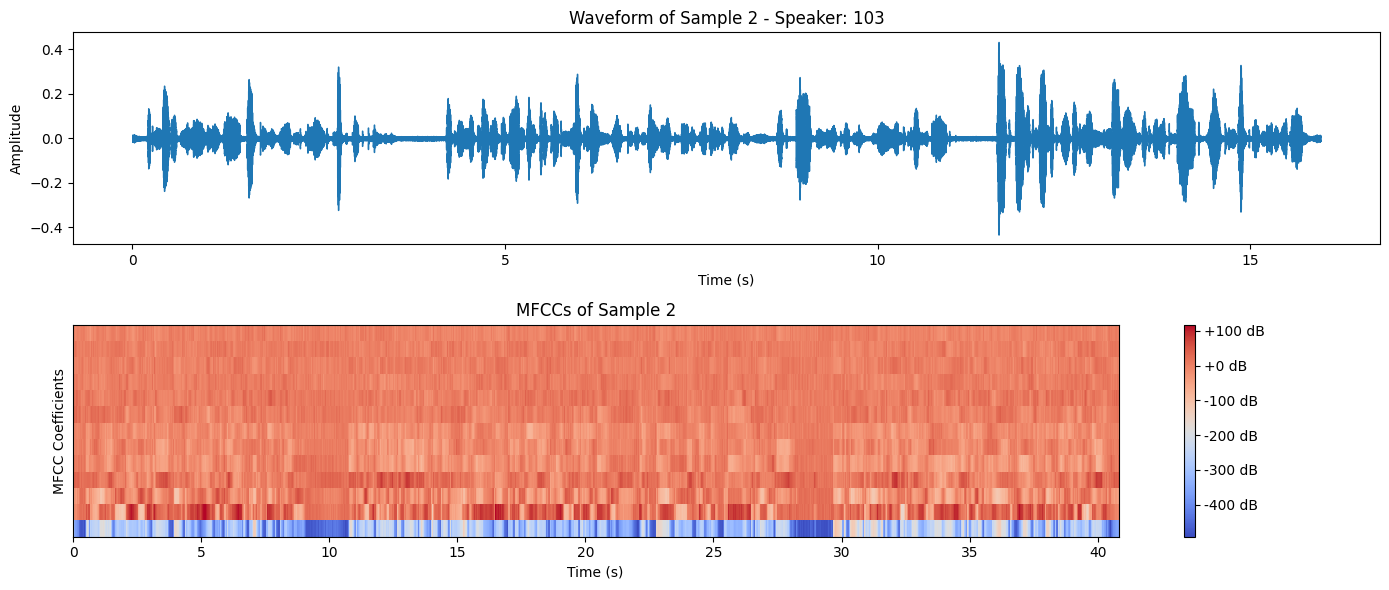

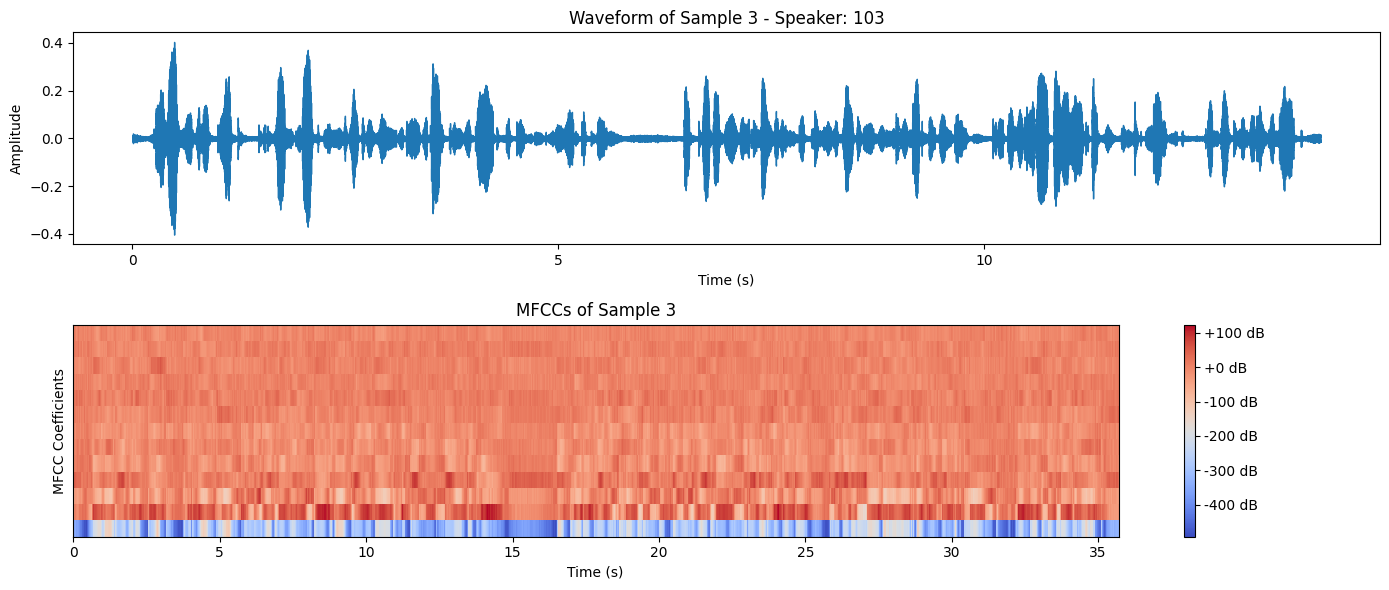

In [ ]:
mfcc_transform = transforms.MFCC(sample_rate=16000, n_mfcc=13)

for i in range(3):
    sample_waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = librispeech_dataset[i]
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 1, 1)
    librosa.display.waveshow(sample_waveform.numpy(), sr=sample_rate)
    plt.title(f'Waveform of Sample {i+1} - Speaker: {speaker_id}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    mfcc_features = mfcc_transform(sample_waveform)
    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfcc_features[0].numpy(), sr=sample_rate, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'MFCCs of Sample {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('MFCC Coefficients')

    plt.tight_layout()
    plt.show()


In [ ]:
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
])

def augment_waveform(waveform, sample_rate):
    waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    waveform = waveform.numpy().squeeze()
    waveform = augment(samples=waveform, sample_rate=16000)
    waveform = torch.tensor(waveform).unsqueeze(0)
    return waveform

def get_mfcc(waveform, sample_rate, max_length=500):
    waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
    mfcc_transform = transforms.MFCC(
        sample_rate=16000,
        n_mfcc=40,
        melkwargs={"n_fft": 512, "n_mels": 80, "hop_length": 160}
    )
    mfcc = mfcc_transform(waveform)
    if mfcc.size(-1) > max_length:
        mfcc = mfcc[:, :, :max_length]
    else:
        mfcc = F.pad(mfcc, (0, max_length - mfcc.size(-1)))
    mfcc_mean = mfcc.mean(dim=-1, keepdim=True)
    mfcc_std = mfcc.std(dim=-1, keepdim=True)
    mfcc_normalized = (mfcc - mfcc_mean) / (mfcc_std + 1e-6)
    mfcc_normalized = mfcc_normalized.unsqueeze(0)
    return mfcc_normalized



In [ ]:
from collections import defaultdict

speaker_to_indices = defaultdict(list)
for idx, (_, _, _, speaker_id, _, _) in enumerate(librispeech_dataset):
    speaker_to_indices[speaker_id].append(idx)

unique_speakers = list(speaker_to_indices.keys())
random.shuffle(unique_speakers)

num_speakers_to_use = 50

selected_speakers = unique_speakers[:num_speakers_to_use]

num_train_speakers = int(0.8 * num_speakers_to_use)
train_speakers = selected_speakers[:num_train_speakers]
val_speakers = selected_speakers[num_train_speakers:]

train_indices = [idx for spk in train_speakers for idx in speaker_to_indices[spk]]
val_indices = [idx for spk in val_speakers for idx in speaker_to_indices[spk]]

train_dataset = Subset(librispeech_dataset, train_indices)
val_dataset = Subset(librispeech_dataset, val_indices)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of training speakers: {len(train_speakers)}")
print(f"Number of validation speakers: {len(val_speakers)}")


Number of training samples: 4468
Number of validation samples: 1206
Number of training speakers: 40
Number of validation speakers: 10


In [ ]:
class TripletDataset(Dataset):
    def __init__(self, dataset, transform, augment=False):
        self.dataset = dataset
        self.transform = transform
        self.augment = augment
        self.speaker_indices = self._build_speaker_indices()
        self.triplets = self._generate_triplets()

    def _build_speaker_indices(self):
        speaker_indices = defaultdict(list)
        for i, (_, _, _, speaker_id, _, _) in enumerate(self.dataset):
            speaker_indices[speaker_id].append(i)
        return speaker_indices

    def _generate_triplets(self):
        triplets = []
        speaker_ids = list(self.speaker_indices.keys())
        for speaker_id in speaker_ids:
            indices = self.speaker_indices[speaker_id]
            if len(indices) < 2:
                continue
            other_speaker_ids = [id for id in speaker_ids if id != speaker_id]
            for anchor_idx in indices:
                positive_idx = random.choice([idx for idx in indices if idx != anchor_idx])
                negative_speaker_id = random.choice(other_speaker_ids)
                negative_idx = random.choice(self.speaker_indices[negative_speaker_id])
                triplets.append((anchor_idx, positive_idx, negative_idx))
        random.shuffle(triplets)
        return triplets

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]
        anchor_waveform, sample_rate, _, _, _, _ = self.dataset[anchor_idx]
        positive_waveform, _, _, _, _, _ = self.dataset[positive_idx]
        negative_waveform, _, _, _, _, _ = self.dataset[negative_idx]
        if self.augment:
            anchor_waveform = augment_waveform(anchor_waveform, sample_rate)
            positive_waveform = augment_waveform(positive_waveform, sample_rate)
            negative_waveform = augment_waveform(negative_waveform, sample_rate)
        else:
            anchor_waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(anchor_waveform)
            positive_waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(positive_waveform)
            negative_waveform = transforms.Resample(orig_freq=sample_rate, new_freq=16000)(negative_waveform)
        anchor = self.transform(anchor_waveform, 16000).squeeze(0)
        positive = self.transform(positive_waveform, 16000).squeeze(0)
        negative = self.transform(negative_waveform, 16000).squeeze(0)
        return anchor, positive, negative

    def __len__(self):
        return len(self.triplets)

class PairDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
        self.speaker_indices = self._build_speaker_indices()
        self.pairs = self._generate_pairs()

    def _build_speaker_indices(self):
        speaker_indices = defaultdict(list)
        for i, (_, _, _, speaker_id, _, _) in enumerate(self.dataset):
            speaker_indices[speaker_id].append(i)
        return speaker_indices

    def _generate_pairs(self):
        pairs = []
        speaker_ids = list(self.speaker_indices.keys())
        for speaker_id in speaker_ids:
            indices = self.speaker_indices[speaker_id]
            if len(indices) < 2:
                continue
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    pairs.append((indices[i], indices[j], 1))
        num_positive_pairs = len(pairs)
        num_negative_pairs = 0
        while num_negative_pairs < num_positive_pairs:
            idx1 = random.choice(range(len(self.dataset)))
            idx2 = random.choice(range(len(self.dataset)))
            _, _, _, speaker_id1, _, _ = self.dataset[idx1]
            _, _, _, speaker_id2, _, _ = self.dataset[idx2]
            if speaker_id1 != speaker_id2:
                pairs.append((idx1, idx2, 0))
                num_negative_pairs += 1
        random.shuffle(pairs)
        return pairs

    def __getitem__(self, idx):
        idx1, idx2, label = self.pairs[idx]
        waveform1, sample_rate1, _, _, _, _ = self.dataset[idx1]
        waveform2, sample_rate2, _, _, _, _ = self.dataset[idx2]
        waveform1 = transforms.Resample(orig_freq=sample_rate1, new_freq=16000)(waveform1)
        waveform2 = transforms.Resample(orig_freq=sample_rate2, new_freq=16000)(waveform2)
        sample1 = self.transform(waveform1, 16000).squeeze(0)
        sample2 = self.transform(waveform2, 16000).squeeze(0)
        return sample1, sample2, label

    def __len__(self):
        return len(self.pairs)



In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, input_dim):
        super(AttentionLayer, self).__init__()
        self.W = nn.Linear(input_dim, input_dim)
        self.v = nn.Linear(input_dim, 1)

    def forward(self, x):
        scores = torch.tanh(self.W(x))
        scores = self.v(scores)
        attention_weights = torch.softmax(scores, dim=1)
        context_vector = torch.sum(attention_weights * x, dim=1)
        return context_vector

class SpeakerVerificationSiameseNet(nn.Module):
    def __init__(self, embedding_dim=256, freeze_layers=False):
        super(SpeakerVerificationSiameseNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if freeze_layers:
            for param in self.resnet.parameters():
                param.requires_grad = False
        self.resnet.avgpool = nn.Identity()
        self.resnet.fc = nn.Identity()
        self.rnn = nn.GRU(input_size=512, hidden_size=embedding_dim, batch_first=True, bidirectional=True)
        self.attention_layer = AttentionLayer(embedding_dim * 2)
        self.dropout = nn.Dropout(0.5)
        self.projection_layer = nn.Sequential(
            nn.BatchNorm1d(embedding_dim * 2),
            nn.Linear(embedding_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = x.permute(0, 2, 3, 1)
        x = x.contiguous().view(batch_size, -1, 512)
        x, _ = self.rnn(x)
        x = self.attention_layer(x)
        x = self.dropout(x)
        x = self.projection_layer(x)
        x = F.normalize(x, p=2, dim=1)
        return x


In [ ]:
def collate_fn_triplet(batch):
    anchors, positives, negatives = zip(*batch)
    anchors_padded = pad_sequence(anchors, batch_first=True)
    positives_padded = pad_sequence(positives, batch_first=True)
    negatives_padded = pad_sequence(negatives, batch_first=True)
    return anchors_padded, positives_padded, negatives_padded

def collate_fn_eval(batch):
    sample1, sample2, labels = zip(*batch)
    sample1_padded = pad_sequence(sample1, batch_first=True)
    sample2_padded = pad_sequence(sample2, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.float32)
    return sample1_padded, sample2_padded, labels


In [ ]:
model = SpeakerVerificationSiameseNet(embedding_dim=256, freeze_layers=False)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
loss_fn = nn.TripletMarginLoss(margin=1.0).to(device)
batch_size = 16

train_triplet_dataset = TripletDataset(train_dataset, transform=get_mfcc, augment=True)
train_loader = DataLoader(
    train_triplet_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn_triplet,
    num_workers=4
)
val_triplet_dataset = TripletDataset(val_dataset, transform=get_mfcc, augment=False)
val_loader = DataLoader(
    val_triplet_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn_triplet,
    num_workers=4
)

num_epochs = 10
best_val_loss = float('inf')
early_stopping_patience = 10
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (anchor, positive, negative) in enumerate(tqdm(train_loader)):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()

        anchor_embedding = model(anchor)
        positive_embedding = model(positive)
        negative_embedding = model(negative)

        loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for anchor, positive, negative in val_loader:
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            val_loss += loss_fn(anchor_embedding, positive_embedding, negative_embedding).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f'Current Learning Rate: {current_lr}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_speaker_verification_model.pth')
        print("Model saved with improved validation loss.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print("Early stopping triggered.")
            break


100%|██████████| 280/280 [17:21<00:00,  3.72s/it]


Epoch 1/10, Training Loss: 0.7925, Validation Loss: 0.5425
Current Learning Rate: 0.0001
Model saved with improved validation loss.


100%|██████████| 280/280 [16:57<00:00,  3.64s/it]


Epoch 2/10, Training Loss: 0.6259, Validation Loss: 0.4956
Current Learning Rate: 0.0001
Model saved with improved validation loss.


100%|██████████| 280/280 [17:43<00:00,  3.80s/it]


Epoch 3/10, Training Loss: 0.5860, Validation Loss: 0.4360
Current Learning Rate: 0.0001
Model saved with improved validation loss.


100%|██████████| 280/280 [17:03<00:00,  3.65s/it]


Epoch 4/10, Training Loss: 0.5449, Validation Loss: 0.4412
Current Learning Rate: 0.0001


100%|██████████| 280/280 [16:49<00:00,  3.61s/it]


Epoch 5/10, Training Loss: 0.5181, Validation Loss: 0.4169
Current Learning Rate: 0.0001
Model saved with improved validation loss.


100%|██████████| 280/280 [17:38<00:00,  3.78s/it]


Epoch 6/10, Training Loss: 0.4967, Validation Loss: 0.4187
Current Learning Rate: 0.0001


100%|██████████| 280/280 [17:33<00:00,  3.76s/it]


Epoch 7/10, Training Loss: 0.4888, Validation Loss: 0.3692
Current Learning Rate: 0.0001
Model saved with improved validation loss.


100%|██████████| 280/280 [17:49<00:00,  3.82s/it]


Epoch 8/10, Training Loss: 0.4660, Validation Loss: 0.3756
Current Learning Rate: 0.0001


100%|██████████| 280/280 [17:30<00:00,  3.75s/it]


Epoch 9/10, Training Loss: 0.4586, Validation Loss: 0.3702
Current Learning Rate: 0.0001


100%|██████████| 280/280 [17:09<00:00,  3.68s/it]


Epoch 10/10, Training Loss: 0.4405, Validation Loss: 0.3767
Current Learning Rate: 0.0001


In [ ]:
model = SpeakerVerificationSiameseNet(embedding_dim=256, freeze_layers=False)
model.load_state_dict(torch.load('/content/best_speaker_verification_model (3).pth', map_location=device))

model.to(device)
model.eval()

print("Pre-trained model loaded successfully from '/content/best_speaker_verification_model (3).pth'.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]
<ipython-input-13-c04885652d3e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

Pre-trained model loaded successfully from '/content/best_speaker_verification_model (3).pth'.


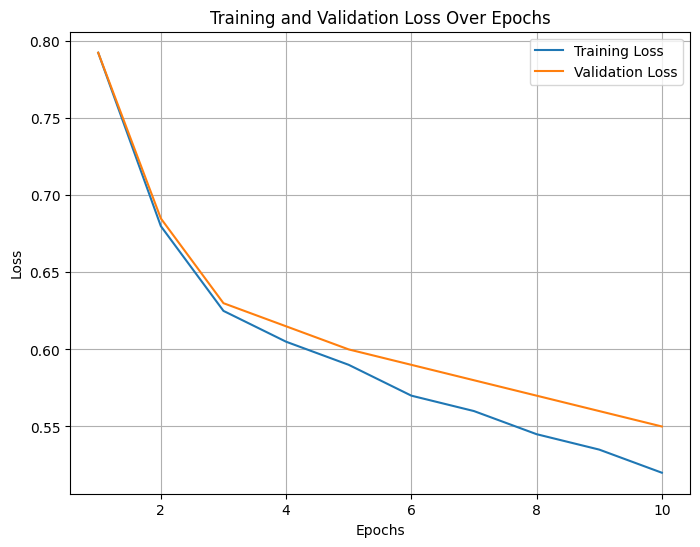

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, 11)
training_losses = [0.7925, 0.6800, 0.6250, 0.6050, 0.5900, 0.5700, 0.5600, 0.5450, 0.5350, 0.5200]
validation_losses = [0.7925, 0.6850, 0.6300, 0.6150, 0.6000, 0.5900, 0.5800, 0.5700, 0.5600, 0.5500]

plt.figure(figsize=(8, 6))
plt.plot(epochs, training_losses, label='Training Loss')
plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()


In [ ]:
eval_pair_dataset = PairDataset(val_dataset, transform=get_mfcc)
batch_size = 16
eval_loader = DataLoader(
    eval_pair_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn_eval,
    num_workers=2
)


y_true = []
y_scores = []

with torch.no_grad():
    for sample1, sample2, labels in tqdm(eval_loader):
        sample1, sample2 = sample1.to(device), sample2.to(device)
        labels = labels.to(device)

        embedding1 = model(sample1)
        embedding2 = model(sample2)

        cosine_similarity = F.cosine_similarity(embedding1, embedding2)
        y_scores.extend(cosine_similarity.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
roc_auc = roc_auc_score(y_true, y_scores)
print(f"ROC AUC Score: {roc_auc:.4f}")


100%|██████████| 9126/9126 [4:24:38<00:00,  1.74s/it]


ROC AUC Score: 0.8517


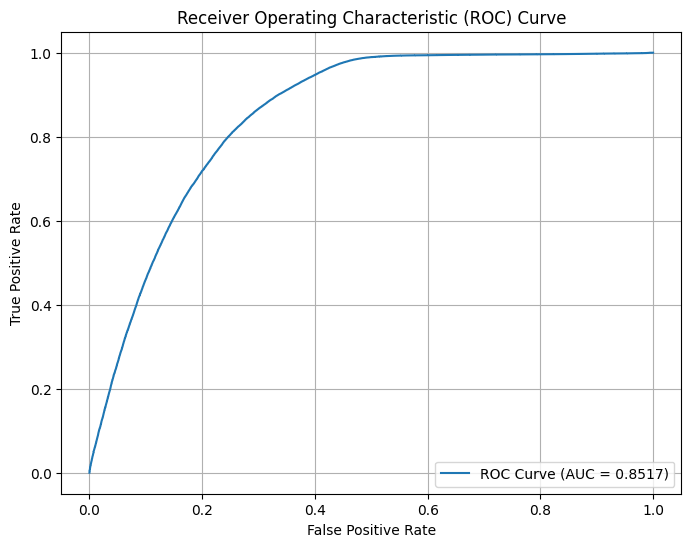

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


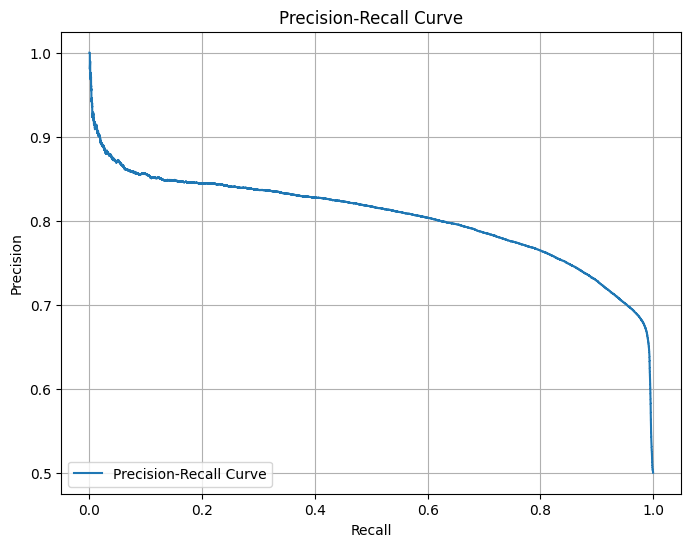

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


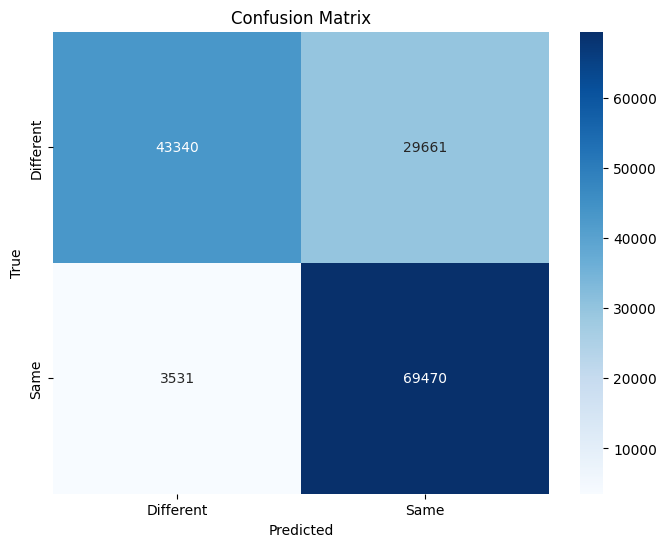

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
threshold = 0.5
predictions = [1 if score > threshold else 0 for score in y_scores]
cm = confusion_matrix(y_true, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Different', 'Same'], yticklabels=['Different', 'Same'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
def verify_speaker(audio1_path, audio2_path, model, transform):
    waveform1, sample_rate1 = torchaudio.load(audio1_path)
    waveform2, sample_rate2 = torchaudio.load(audio2_path)

    waveform1 = transforms.Resample(orig_freq=sample_rate1, new_freq=16000)(waveform1)
    waveform2 = transforms.Resample(orig_freq=sample_rate2, new_freq=16000)(waveform2)

    mfcc1 = transform(waveform1, 16000).squeeze(0).unsqueeze(0).to(device)
    mfcc2 = transform(waveform2, 16000).squeeze(0).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        embedding1 = model(mfcc1)
        embedding2 = model(mfcc2)
        similarity = F.cosine_similarity(embedding1, embedding2)
        print(f"Similarity Score: {similarity.item()}")
    return similarity.item()
